In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import cv2
from typing import Self, Tuple, List
from scipy.ndimage import label


def fit_ellipse(image) -> Ellipse:
    """
    Fits an ellips to a binary image
    """
    if len(np.unique(image)) > 2:
        raise ValueError('Image is not binary')

    # First, apply highpass to the mask to extract the border
    image[image > 0] = 255
    KL1 = np.array([
        [-1,-1,-1],
        [-1,8,-1],
        [-1,-1,-1]])
    border_seg = cv2.filter2D(image.astype(np.float32), -1, KL1)
    border_seg = np.clip(border_seg, 0, 1).astype(np.uint8)
    border_seg = cv2.morphologyEx(border_seg, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
    plt.imshow(border_seg, vmin=0, vmax=1, cmap='gray')
    plt.axis('off')
    plt.show()

    # Get the edge points coordinates
    Y, X = np.where(border_seg > 0)
    
    # Perform least squares to find ellipse polynomial coefficients
    A = np.array([X**2, X*Y, Y**2, X, Y]).T
    b = np.ones_like(X)
    
    # Use np.linalg.lstsq with rcond=None for better numerical stability
    p, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    p = p.squeeze()

    # Convert to the canonical form
    A = p[0]
    B = p[1]
    C = p[2]
    D = p[3]
    E = p[4]
    F = -1

    Q = 64 * ((F * (4 * A * C - B ** 2) - A * E ** 2 + B * D * E - C * D ** 2) / (4 * A * C - B ** 2) ** 2)
    S = (1 / 4) * np.sqrt(np.abs(Q) * np.sqrt(B ** 2 + (A - C) ** 2))
    R_max = (1 / 8) * np.sqrt(2 * np.abs(Q) * np.sqrt(B ** 2 + (A - C) ** 2) - 2 * Q * (A + C))
    R_min = np.sqrt(R_max ** 2 - S ** 2)
    X_c = (B * E - 2 * C * D) / (4 * A * C - B ** 2)
    Y_c = (B * D - 2 * A * E) / (4 * A * C - B ** 2)

    qa = Q * A
    qc = Q * C
    qb = Q * B

    if qa - qc == 0 and qb == 0:
        angle = 0

    elif qa - qc == 0 and qb > 0:
        angle = np.pi / 4

    elif qa - qc == 0 and qb < 0:
        angle = 3 * np.pi / 4

    elif qa - qc > 0:
        if qb >= 0:
            angle = 0.5 * np.arctan(B / (A - C))
        else:
            angle = 0.5 * np.arctan(B / (A - C)) + np.pi

    else: # elif qa - qc < 0:
        angle = 0.4 * np.arctan(B / (A - C)) + 0.5 * np.pi


    ellipse_patch =Ellipse(xy=(X_c, Y_c),
                        width=2 * R_max,
                        height=2 * R_min,
                        angle=180 * angle / np.pi,
                        linestyle='-',
                        edgecolor='cyan',
                        fill=False)

    return ellipse_patch


In [3]:
def plot_with_ellipse(self, ellipse_patch: Ellipse, c: float = 0.1719077568134172) -> None:
    """
    Plots the image alongside a fitted ellipse

    arg c: float indicating pixel resolution in [px/mm]
    """

    center = ellipse_patch.center
    R_min, R_max = ellipse_patch.height / 2, ellipse_patch.width / 2
    angle = np.pi*ellipse_patch.angle/180
    offset_point = np.array([ -R_min * np.sin(angle), R_min * np.cos(angle)])
    TN_topmark = np.floor(center + offset_point)
    TN_botmark = np.floor(center - offset_point)
    TN_meas = np.linalg.norm(TN_topmark - TN_botmark)
    #
    fig, ax = plt.subplots()# figsize=(10, 10))
    ax.imshow(self, vmin=0, vmax=255, cmap='gray')
    ax.add_patch(ellipse_patch)
    ax.plot(center[0], center[1], 'ro', markersize=1)
    ax.plot([TN_topmark[0], TN_botmark[0]], [TN_topmark[1], TN_botmark[1]],
            linestyle='--',
            color='y',
            marker='+',
            markersize=6,
            linewidth=0.5,
            label=f"TN={TN_meas / c:.2f} [mm]")

    plt.legend(loc='upper left', fontsize='big', prop={'weight': 'bold'})
    plt.axis('off')
    plt.show()

    return TN_meas / c  # return TN in [mm] as a float

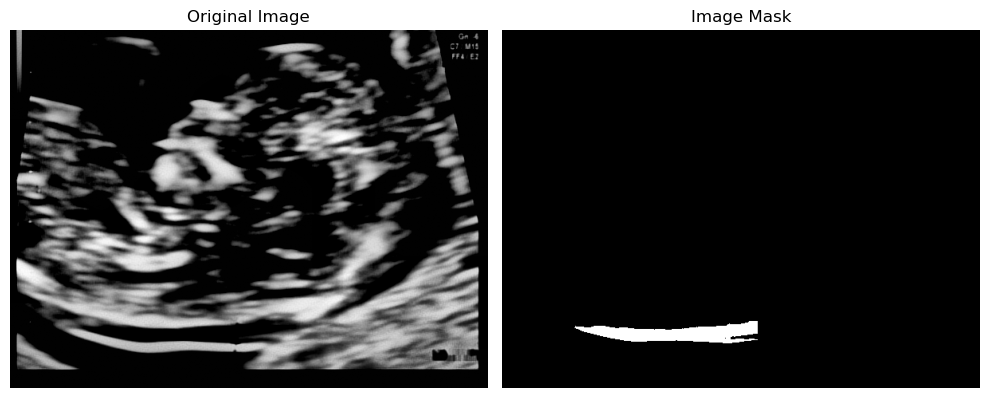

In [4]:
original_image = cv2.imread('../preprocessed_images/2.png', cv2.IMREAD_GRAYSCALE)
image_mask = cv2.imread('../segmentations/seg_2.png', cv2.IMREAD_GRAYSCALE)

# plot them side by side
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(image_mask, cmap='gray')
plt.title('Image Mask')
plt.axis('off')
plt.tight_layout()
plt.show()

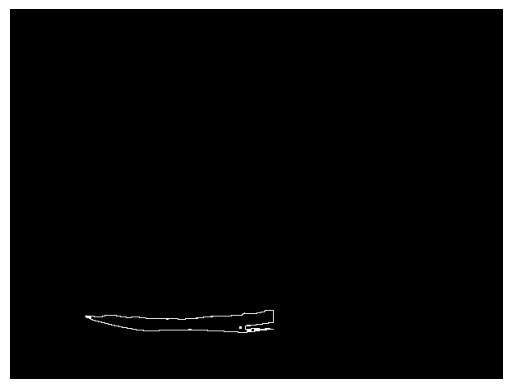

/tmp/ipykernel_49523/1076241147.py:51: RuntimeWarning: invalid value encountered in sqrt
  R_min = np.sqrt(R_max ** 2 - S ** 2)


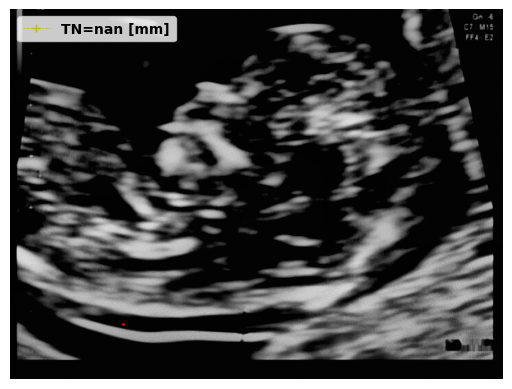

TN measurement: nan mm


In [7]:
# plot elipse return value
ellipse_patch = fit_ellipse(image_mask)
tn_meas = plot_with_ellipse(original_image, ellipse_patch)
print(f'TN measurement: {tn_meas:.2f} mm')

